In [1]:
import torch 
import numpy as np
import matplotlib.pyplot as plt

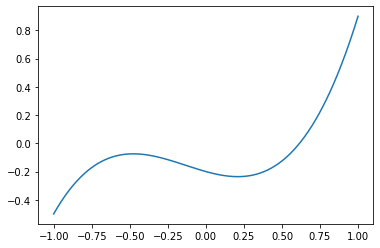

In [10]:
f = np.vectorize (  lambda x: x*x*x + 0.4*x*x - 0.3 * x - 0.2)
x = np.linspace(-1., 1., num=500)
plt.plot(x, f(x))
plt.show()

Shape =  (1000, 2)


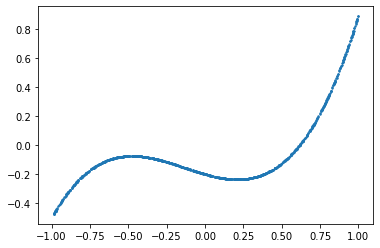

In [21]:
def generate_samples(n = 1000):
    x = np.random.random(n) * 2 - 1.
    y = f(x)
    return np.vstack((x , y)).T    # shape = (n, 2)

samples = generate_samples(1000)
print('Shape = ',samples.shape)
plt.scatter(samples[:,0], samples[:,1], s = 2)
plt.show()

In [24]:
def generate_samples_fake(n = 1000):
    x = np.random.random(n) * 2 - 1.
    y = np.random.random(n) * 2 - 1.
    return np.vstack((x , y)).T

First try out discriminating without a generator network.

 We feed in real sample and fake samples in each 
epoch and let the discriminator network learn how to distinguish them.

In [179]:
discriminator = torch.nn.Sequential(
    torch.nn.Linear(2,50),
    torch.nn.ReLU(), 
    torch.nn.Linear(50,30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,2),
    torch.nn.Sigmoid()
)

In [180]:
from tqdm import tqdm 
epochs = 1200
batch_size = 200
assert batch_size % 2 == 0
losses = []

optimizer = torch.optim.Adam(discriminator.parameters())
loss_f = torch.nn.CrossEntropyLoss()

for epoch in tqdm(range(epochs)):
    samples_real = generate_samples(batch_size // 2)
    samples_fake = generate_samples_fake(batch_size // 2)
    samples = np.vstack((samples_real,samples_fake))

    labels = np.array([1] * (batch_size // 2)  +  [0] * (batch_size // 2))
    
    shuffle = np.arange(batch_size)
    np.random.shuffle(shuffle)
    samples = torch.Tensor(samples[shuffle])
    labels = torch.Tensor(labels[shuffle]).long()

    predicts = discriminator(samples)
    
    loss = loss_f(predicts, labels)
    losses.append(loss.item())

    # update parameters by gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 1200/1200 [00:01<00:00, 656.10it/s]


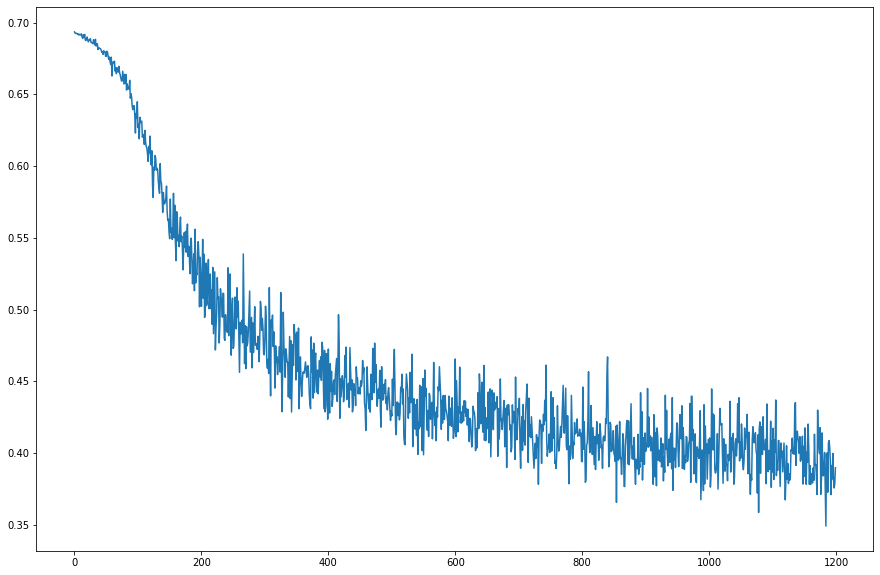

In [181]:
plt.figure(figsize=(15,10))
plt.plot(losses)

Accuracy on real data = 100.0%
Accuracy on fake data = 85.8%
Accuracy on all  data = 92.9%


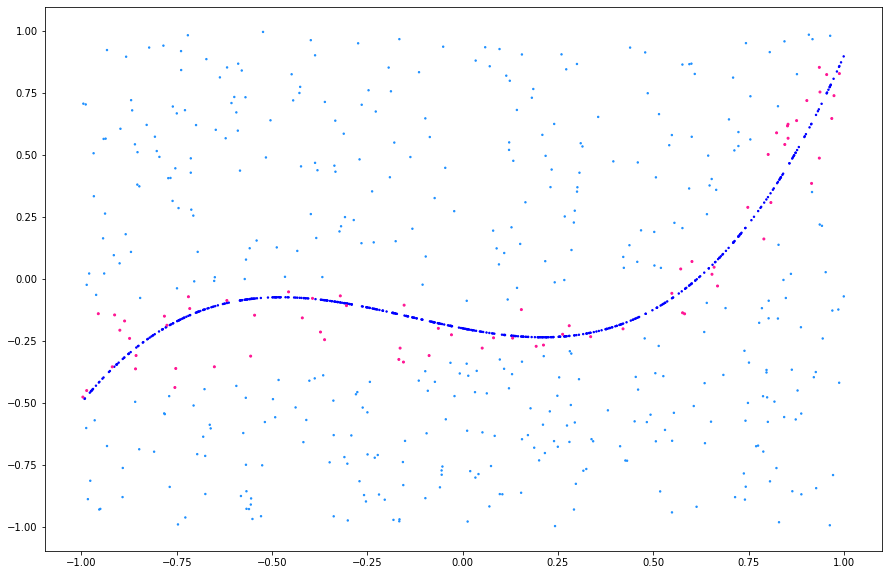

In [191]:
velidate_size = 1000
samples_real = generate_samples(velidate_size // 2)
samples_fake = generate_samples_fake(velidate_size // 2)

with torch.no_grad():
    predicts_real = discriminator(torch.Tensor(samples_real)).detach().numpy()
    predicts_fake = discriminator(torch.Tensor(samples_fake)).detach().numpy()

predicts_real = np.argmax(predicts_real, axis=-1)
predicts_fake = np.argmax(predicts_fake, axis=-1)

acc_real = sum(predicts_real) / predicts_real.size 
acc_fake = 1. - sum(predicts_fake) / predicts_fake.size
acc_total = (acc_real + acc_fake) * 0.5
print(f'Accuracy on real data = {acc_real*100}%')
print(f'Accuracy on fake data = {acc_fake*100}%')
print(f'Accuracy on all  data = {acc_total*100}%')

plt.figure(figsize=(15,10))
plt.scatter(samples_real[:,0], samples_real[:,1],   
            s = [(4,2)[i] for i in predicts_real],
            c = [('#FF1493','#0000FF')[i] for i in predicts_real])
plt.scatter(samples_fake[:,0], samples_fake[:,1], 
            s = [(2,4)[i] for i in predicts_fake],
            c = [('#1E90FF','#FF1493')[i] for i in predicts_fake])
plt.show()

All the samples that are predicted wrong are marked pink (and enlarged) in the figure above.

It is unsurprising that the accuracy on the fake samples cannot reach 100%, just because some of the fake samples we generate accidentally fall too near to the blue line.

Now we start a GAN model: a generator and also a discriminator.

In [231]:
latent_dim = 5

generator = torch.nn.Sequential(
    torch.nn.Linear(latent_dim, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50,30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,2)
)

discriminator = torch.nn.Sequential(
    torch.nn.Linear(2,50),
    torch.nn.ReLU(), 
    torch.nn.Linear(50,30),
    torch.nn.ReLU(),
    torch.nn.Linear(30,2),
    torch.nn.Softmax(dim=-1)  # we use softmax here to automatically obtain probabilities
)

optimizer_gen = torch.optim.Adam(generator.parameters())
optimizer_dis = torch.optim.Adam(discriminator.parameters())

https://arxiv.org/abs/1406.2661

In [232]:
from tqdm import tqdm 
epochs = 2500
miniepochs = 3
batch_size = 200

for epoch in tqdm(range(epochs)):    
    for miniepoch in range(miniepochs):
        # sample random seeds (in the latent space) to generate fake data
        latent_seeds = np.random.randn(batch_size // 2, latent_dim)
        latent_seeds = torch.Tensor(latent_seeds)
        samples_fake = generator(latent_seeds)

        samples_real = torch.Tensor( generate_samples(batch_size // 2) )

        predicts_real = discriminator(samples_real)
        predicts_fake = discriminator(samples_fake)

        loss  = torch.sum(torch.log(predicts_real[:,1])) # the prob of real data predicted to be real
        loss += torch.sum(torch.log(predicts_fake[:,0])) # the prob of fake data predicted to be fake
        loss *= ( -1. / batch_size ) # maximize the two probabilites defined above

        optimizer_dis.zero_grad()
        loss.backward()
        optimizer_dis.step()
    
    latent_seeds = np.random.randn(batch_size // 2, latent_dim)
    latent_seeds = torch.Tensor(latent_seeds)
    samples_fake = generator(latent_seeds)
    predicts_fake = discriminator(samples_fake)

    loss = torch.sum(torch.log(predicts_fake[:,0])) # the prob of fake data predicted to be fake
    loss *= 1. / batch_size # minimize the probability defined above

    # here the discriminator is not trained, so set .trainable == False in tensorflow
    optimizer_gen.zero_grad()
    loss.backward()
    optimizer_gen.step()

100%|██████████| 2500/2500 [00:22<00:00, 113.13it/s]


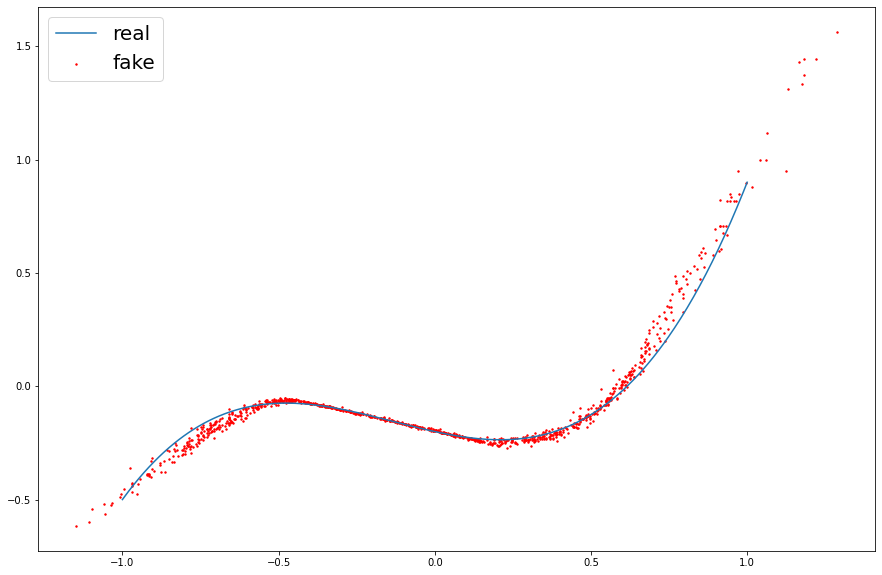

In [233]:
latent_seeds = np.random.randn(1000, latent_dim)
latent_seeds = torch.Tensor(latent_seeds)
samples_fake = generator(latent_seeds).detach().numpy()

x = np.linspace(-1., 1., num=500)
plt.figure(figsize=(15,10))
plt.plot(x, f(x))
plt.scatter(samples_fake[:,0], samples_fake[:,1], s=2, c='r')
plt.legend(['real','fake'], fontsize=20)
plt.show()

Our target is to train the generator to generate good enough fake data points to cheat the discriminator.

In [234]:
predicts_fake = discriminator( torch.Tensor(samples_fake) ).detach().numpy()
predicts_fake = np.argmax(predicts_fake, axis=-1)
acc_fake = 1. - np.sum(predicts_fake) / predicts_fake.size
print(f'Accuracy on generated data = {acc_fake*100}%')

Accuracy on generated data = 67.10000000000001%
